In [3]:
from functions_py import *
from functions_MuonsNSAMP1 import *
import matplotlib.pyplot as plt
# import matplotlib as mpl
# from mpl_toolkits.axes_grid1 import make_axes_locatable
# import numpy.ma as ma
# import pandas as pd 
import scipy as  scy 
# from sympy.abc import u
# import cv2
import skimage as sk
import random
import time

def gaussian(x, a, mean, sigma):
    return a * np.exp(-((x - mean)**2 / (2 * sigma**2)))

def Gaussian2(x,m1,s1,g1,a1, m2, s2, g2, a2): #data, mean, sigma, gain, height1, heigth2
    return a1*np.exp(-1/2*((x-m1-g1)/s1)**2) + a2*np.exp(-1/2*((x-m2-g2)/s2)**2)

def Landau(x,a, MP,xi):
    C1 = a/np.sqrt((2 * np.pi))
    C2 = np.exp(-((x-MP)-1)/xi)
    C3 = np.exp((-0.5 * (((x-MP)-1)/xi + C2 )))

    # C1 = 1/np.sqrt((2 * np.pi))
    # C3 = np.exp((-0.5 * (x + np.exp(-x))))
    return  C1 * C3


def EnergySpectrum(x, N):
    return N * np.sin(x)*np.cos(x)**3

Welcome to JupyROOT 6.28/04


In [4]:
## Configuración de estilo de gráficas  ##
plt.rcParams.update({
    "image.origin": "lower",
    "image.aspect": 1,
    #"text.usetex": True,
    "grid.alpha": .5,
    "axes.linewidth":2,
    "lines.linewidth" : 1,
    "font.size":    15.0,
    "xaxis.labellocation": 'right',  # alignment of the xaxis label: {left, right, center}
    "yaxis.labellocation": 'top',  # alignment of the yaxis label: {bottom, top, center}
    "xtick.top":           True ,  # draw ticks on the top side
    "xtick.major.size":    8    ,# major tick size in points
    "xtick.minor.size":    4      ,# minor tick size in points
    "xtick.direction":     'in',
    "xtick.minor.visible": True,
    "ytick.right":           True ,  # draw ticks on the top side
    "ytick.major.size":    8    ,# major tick size in points
    "ytick.minor.size":    4      ,# minor tick size in points
    "ytick.direction":     'in',
    "ytick.minor.visible": True,
    "ytick.major.width":   2   , # major tick width in points
    "ytick.minor.width":   1 ,
    "xtick.major.width":   2   , # major tick width in points
    "xtick.minor.width":   1 ,
    "legend.framealpha": 0 ,
    "legend.loc": 'best',

})

# Gráfica de Bethe-Bloch

In [7]:
K_Bethe = 0.1535 #MeVcm²/g

# Silicon Properties
Z = 14
A = 28.085
a = 0.1492
I = 0.000173 # MeV
C0 = -4.4
X1 = 2.87
m = 3.25
electron_mass = 0.510998950 # MeV/c²
muon_mass = 105.66 #MeV/c²
density = 2.33 # g/cm^3

potencial_I = Z * (9.76 + 58.8 * Z **(-1.19))

# Muon Properties
muon_velocity = 0.998 # times c
beta = 0.998
gamma = np.sqrt(1 - beta**2)**(-1)
eta = beta * gamma
x = np.log10(beta * gamma)
delta = 4.6052 * x + C0 + a*(X1 - x)**m
shell_correction_1 = ( 0.422377 * eta**(-2) + 0.0304043 * eta**(-3) - 0.00038106 * eta**(-6)) * 10**(-6) * I**2
shell_correction_2 = (3.850190 * eta**(-2) - 0.16679891 * eta**(-4) + 0.00157955* eta**(-6)) * 10**(-9) * I**3
shell_correction = shell_correction_1 + shell_correction_2
W_max = 2 * electron_mass * eta**2

print('eta: ', eta, '\nX:', x, '\ndelta: ', delta, '\nC(I, eta): ', shell_correction, '\nW_max: ', W_max, end = '\n') 

print("Valor de I usando la fórmula: ", potencial_I)

eta:  15.787661329349902 
X: 1.1983178015103988 
delta:  1.9110280576503402 
C(I, eta):  5.0948711330246794e-17 
W_max:  254.73323233023027
Valor de I usando la fórmula:  172.25336405711283


In [8]:
def Bethe_Bloch (velocity):
    K_Bethe = 0.1535 #MeVcm²/g
    Zeta = float(14)
    A = 28.085
    a = 0.1492
    I = 0.000173 # MeV
    C0 = -4.4
    X1 = 2.87
    X0 = 0.2014
    m = 3.25
    electron_mass = 0.510998950 # MeV/c²
    density = 2.33  # g/cm^3 
    list_delta= []

    Beta = velocity
    Gamma = 1/np.sqrt(1-Beta**2)
    Eta = Beta * Gamma
    # W = (2 * electron_mass * Eta**2) / (1 + 2*(electron_mass/muon_mass) * np.sqrt(1 + Eta**2) + (electron_mass/muon_mass)**2)
    W = (2 * electron_mass * Eta**2)
    C_1 = K_Bethe * (Zeta/A) * (1/Beta**2)
    C_21 = np.log((2 * electron_mass * Gamma**2 * velocity**2 * W)/(I**2))
    C_22 = 2 * Beta**2
    X = np.log10(Eta)
    
    for element in X:
        if element < X0:
            C_23 = 0
            list_delta.append(element)
        if X0 < element < X1:
            C_23 = 4.6052 * element - C0 + a*(X1 - element)**m
            list_delta.append(element)
        if element > X1:
            C_23 = 4.6052 * element - C0
            list_delta.append(element)
    delta = np.array(list_delta) 
    del X

    Shell_correction =  ( 0.422377 * Eta**(-2) + 0.0304043 * Eta**(-3) - 0.00038106 * Eta**(-6)) * 10**(-6) * I**2 + \
                        ( 3.850190 * Eta**(-2) - 0.16679891 * Eta**(-4) + 0.00157955* Eta**(-6)) * 10**(-9) * I**3
    C_24 = 2 * (Shell_correction/Zeta)

    C_25 = C_22 + delta + C_24

    C_2 = C_21 - C_25
    with_corrections = C_1 * C_2 
    without_correction = C_1 * (C_21 - C_22)
    return with_corrections, without_correction #MeVcm^2/g


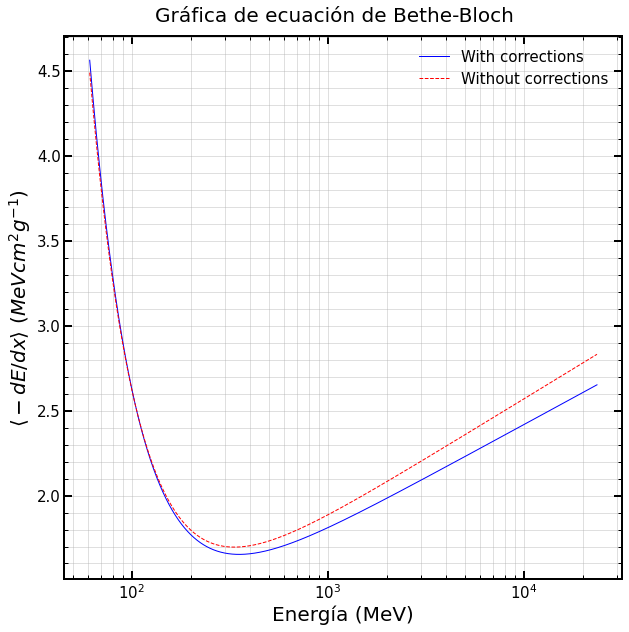

In [9]:
muon_mass = 105.66 #MeV/c²
muon_velocities = np.linspace(0.5, 0.99999,1000000)
beta_gamma = muon_velocities /np.sqrt(1 - muon_velocities**2)
energy = beta_gamma * muon_mass
dEdL_corrections, dEdL = Bethe_Bloch(muon_velocities)

fig, axs = plt.subplots(figsize=[10,10])
axs.plot(energy, dEdL_corrections, 'b', label='With corrections')
axs.plot(energy, dEdL, '--r', label='Without corrections')
axs.set_xscale('log')
# axs.set_yscale('log')
axs.grid(which='both')
axs.set_xlabel(r'Energía (MeV)', loc='center', weight='normal', size=20)
axs.set_ylabel(r'$\langle -dE/dx \rangle ~(MeV cm^2 g^{-1})$', loc='center', weight='normal', size=20 )
# axs.set_ylim(1.6, 2.1)
axs.legend()
fig.suptitle('Gráfica de ecuación de Bethe-Bloch', y = 0.92, size = 20)
plt.show()
# plt.yscale('log')
# plt.xlim([0.1,10])
# plt.ylim([1,2])

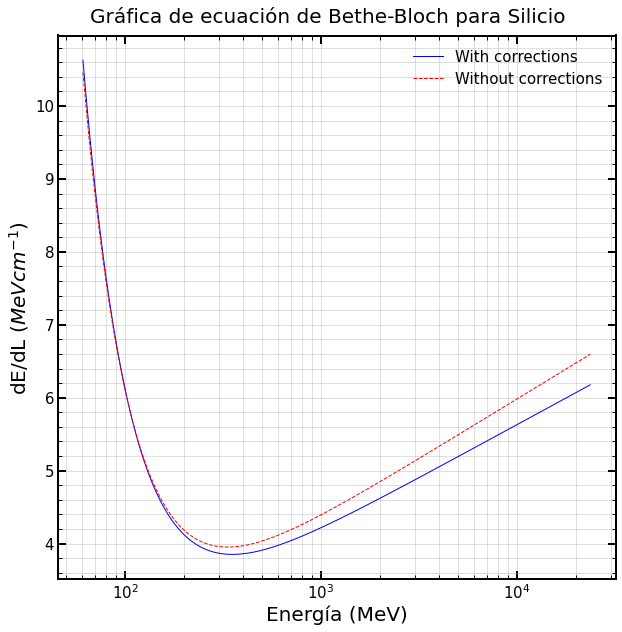

In [10]:
density = 2.329 
dEdL_corrections, dEdL = Bethe_Bloch(muon_velocities) 
fig, axs = plt.subplots(figsize=[10,10])
axs.plot(energy, dEdL_corrections*density, 'b', label='With corrections')
axs.plot(energy, dEdL * density, '--r', label='Without corrections')
axs.set_xscale('log')
axs.grid(which='both')
axs.set_xlabel('Energía (MeV)', loc='center', weight='normal', size=20)
axs.set_ylabel(r'dE/dL $(MeVcm^{-1})$', loc='center', weight='normal', size=20 )
# axs.set_yticklabels([4,])
fig.suptitle('Gráfica de ecuación de Bethe-Bloch para Silicio', y = 0.92, size = 20)
# axs.set_ylim(0.1, 0.4)
axs.legend()
plt.show()

In [11]:
print('El valor mínimo del dE/dL es: ', dEdL_corrections.min() * density)
print('Para este valor, la energía promedio que depositan los muones en 0.0725cm de silicio es: ', dEdL_corrections.min() * density * 0.0725 * 1000, ' KeV')

El valor mínimo del dE/dL es:  3.85119209287138
Para este valor, la energía promedio que depositan los muones en 0.0725cm de silicio es:  279.2114267331751  KeV


# Valor medio de la ecuación de Bethe-Bloch para Silicio

In [12]:
def Bethe_Bloch_value(energy):
    K_Bethe = 0.1535 #MeVcm²/g
    Zeta = float(14)
    A = 28.085
    a = 0.1492
    I = 0.000173 # MeV
    C0 = -4.4
    X1 = 2.87
    X0 = 0.2014
    m = 3.25
    light_vel = 3 *10 **8
    electron_mass = 0.510998950 # MeV/c²
    density = 2.33  # g/cm^3 

    Gamma = energy / muon_mass
    Beta = np.sqrt(1 - 1/(Gamma**2))
    Eta = Beta * Gamma
    velocity = Beta
    
    # W = (2 * electron_mass * Eta**2) / (1 + 2*(electron_mass/muon_mass) * np.sqrt(1 + Eta**2) + (electron_mass/muon_mass)**2)
    W = (2 * electron_mass * Eta**2)
    C_1 = K_Bethe * (Zeta/A) * (1/Beta**2)
    C_21 = np.log((2 * electron_mass * Gamma**2 * velocity**2 * W)/(I**2))
    C_22 = 2 * Beta**2
    X = np.log10(Eta)

    if X < X0:
        C_23 = 0
    if X0 < X < X1:
        C_23 = 4.6052 * X - C0 + a*(X1 - X)**m
    if X > X1:
        C_23 = 4.6052 * X - C0

    Shell_correction =  ( 0.422377 * Eta**(-2) + 0.0304043 * Eta**(-3) - 0.00038106 * Eta**(-6)) * 10**(-6) * I**2 + \
                        ( 3.850190 * Eta**(-2) - 0.16679891 * Eta**(-4) + 0.00157955* Eta**(-6)) * 10**(-9) * I**3
    C_24 = 2 * (Shell_correction/Zeta)

    C_25 = C_22 + delta + C_24
    C_2 = C_21 - C_25

    
    with_corrections = C_1 * C_2 *density * 0.0725 * 1000
    without_correction = C_1 * (C_21 - C_22) * density* 0.0725 * 1000
    return with_corrections, without_correction #KeV


In [13]:
mean_energy = 720.7999999
Bethe_corr, Bethe = Bethe_Bloch_value(mean_energy)
print('Valor de la energía de Bethe-Bloch para muones de ', mean_energy, 'MeV con correcciones: ', Bethe_corr, ' KeV')
print('y sin correcciones: ', Bethe, ' KeV')

Valor de la energía de Bethe-Bloch para muones de  720.7999999 MeV con correcciones:  279.2113335711371  KeV
y sin correcciones:  304.4552496073883  KeV


# Gráfica de Valor mas probable

In [5]:
def delta_P(velocity, thickness):
    list_delta = []
    K_Bethe = 0.1535 #MeVcm²/g
    Z = 14
    A = 28.085
    I = 0.000000173 # MeV (En el R.W. Leo)
    j = 0.2
    a = 0.1492
    C0 = -4.4
    X1 = 2.87
    X0 = 0.2014
    m = 3.25

    # thickness = 0.168789063 # g/cm² (equivalent to 725 micras)
    # thickness = 0.168925 # g/cm² (equivalent to 725 micras)
    muon_mass = 105.66 #MeV/c²
    electron_mass = 0.510998950 # MeV/c²

    Beta = velocity
    Gamma = 1/np.sqrt(1-Beta**2)
    Eta = Beta * Gamma
    xi = (K_Bethe) * (Z / A) * (thickness/ Beta**2) 
    
    C_1 = np.log((2 * electron_mass * Beta**2 * Gamma**2)/(I))
    C_2 = np.log(xi/I)
    C_3 = j - Beta**2

    X = np.log10(Eta)
    for element in X:
        if element < X0:
            C_23 = 0
            list_delta.append(element)

        if X0 <= element < X1:
            C_23 = 2 * np.log(10) * element - C0 + a*(X1 - element)**m
            list_delta.append(element)

        if element >= X1:
            C_23 = 2 * np.log(10) * element - C0
            list_delta.append(element)

    delta_eta = np.array(list_delta) 
    del X

    C_4 = C_3 - delta_eta

    dP = xi * (C_1 + C_2 + C_3)
    dP_delta_eta = xi * (C_1 + C_2 + C_4) / thickness
    # dP_scaled = dP/thickness
    return [dP, dP_delta_eta]

Min of Delta_P/(dE/dx_min) for x = 80 $\mu m$ :  1.2635966740874318
Min of Delta_P/(dE/dx_min) for x = 160 $\mu m$ :  1.296434022804976
Min of Delta_P/(dE/dx_min) for x = 320 $\mu m$ :  1.329186225083847
Min of Delta_P/(dE/dx_min) for x = 640 $\mu m$ :  1.3618542057480298
Min of Delta_P/(dE/dx_min) for x = 725 $\mu m$ :  1.36775217224674


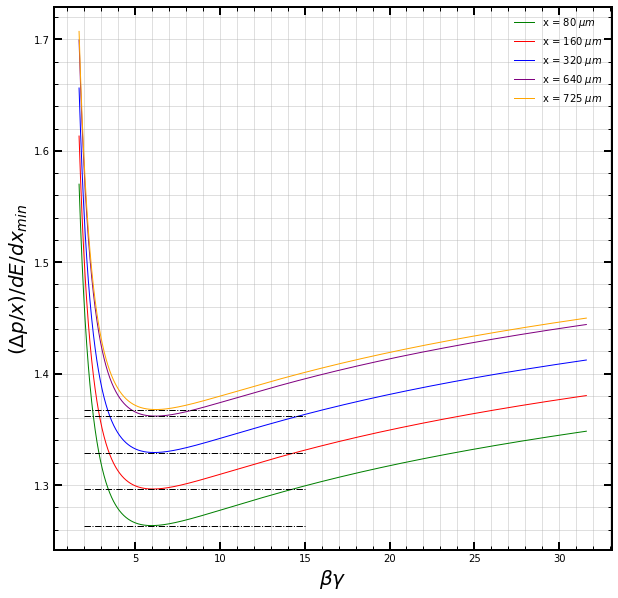

In [15]:
muon_mass = 105.66 #MeV/c²

muon_velocities = np.linspace(0.86, 0.9995,1000000)
beta_gamma = muon_velocities /np.sqrt(1 - muon_velocities**2)
energy = beta_gamma * muon_mass
list_thickness = [0.0187, 0.0374, 0.0747, 0.149, 0.168789063]  # g/cm^2
# list_thickness = [0.168789063]  # g/cm^2

list_micra_thickness = [80, 160, 320, 640, 725] #micras
# list_micra_thickness = [725] #micras

list_colors = ['g', 'r', 'b', 'purple', 'orange']

fig, axs = plt.subplots(figsize=[10,10])
for index in np.arange(0, len(list_thickness)):
    delP_scaled, delP_delta_scaled = delta_P(muon_velocities, list_thickness[index])
    curve_name = 'x = ' + str(list_micra_thickness[index]) + r' $\mu m$ '
    # print('Min of Delta_P: ', np.min(delP_scaled))
    print('Min of Delta_P/(dE/dx_min) for ' + curve_name + ': ', np.min(delP_delta_scaled/1.66))

    # axs.plot(beta_gamma, delP_scaled/1.66, label=curve_name)
    axs.plot(beta_gamma, delP_delta_scaled/1.66, label=curve_name, color= list_colors[index])
    axs.hlines(y= np.min(delP_delta_scaled/1.66), xmin = 2, xmax = 15, linestyles='dashdot', colors='black')
    # axs.plot( 4.5, np.min(delP_delta_scaled/1.66), 'ok')

# axs.set_xscale('log')
axs.grid(which='both')
axs.set_xlabel(r'$\beta \gamma$', loc='center', weight='normal', size=20)
axs.set_ylabel(r'$(\Delta p / x)/dE/dx_{min}$', loc='center', weight='normal', size=20 )
# axs.set_yticklabels([4,])
# fig.suptitle('Gráfica de ecuación de Bethe-Bloch para Silicio', y = 0.92, size = 20)
# axs.set_ylim(0.1, 0.4)
axs.legend()
plt.show()

## Valor mas probable

In [69]:
def Delta_mp_Leo(energy, thickness):
    K_Bethe = 0.1535 #MeVcm²/g
    Z = 14
    A = 28.085
    I = 0.000000174 # MeVc
    a = 0.1492
    C0 = -4.4
    X1 = 2.87
    X0 = 0.2014
    m = 3.25
    muon_mass = 105.66 #MeV/c²
    electron_mass = 0.510998950 # MeV/c²

    # bg = energy / muon_mass
    # Beta = bg/np.sqrt(1+ (bg**2))
    # gamma = 1/np.sqrt(1-(beta**2))

    gamma = (energy + muon_mass) / muon_mass 
    Beta = np.sqrt(1 - 1/(gamma**2))

    Eta = Beta * gamma
    X = np.log10(Eta)

    if X < X0:
        C_23 = 0
    if X0 < X < X1:
        C_23 = 4.6052 * X - C0 + a*(X1 - X)**m
    if X > X1:
        C_23 = 4.6052 * X - C0


    ln_eps = np.log(((1 - Beta**2) * (I**2))/(2 * electron_mass * Beta**2)) + Beta**2 
    # element = np.log10(Beta * Gamma)

    xi = K_Bethe * density * Z * thickness/ (A * Beta**2) 

    # return xi * (np.log(xi) - ln_eps + 0.198- C_23)
    return xi * (np.log(xi/np.exp(ln_eps)) + 0.198 - C_23)

In [70]:
mp = Delta_mp_Leo(mean_energy,  0.0725) # MeV
print('El valor mas probable de Landau es ', mp, ' MeV, ó ', mp * 1000,  ' KeV' )
# print('O ', mp * 1000 * 1000, ' eV/micras' )

El valor mas probable de Landau es  0.2660812893754627  MeV, ó  266.0812893754627  KeV


# Distribución de Landau

In [57]:
def phi_factor(x, alfa):
    return np.exp(- x * np.log(x) - x * alfa) * np.sin(x * np.pi)
    

def Landau_dis(thickness, energy):
    # Costantes
    K_Bethe = 0.1535 #MeVcm²/g
    # K_Bethe = 153.5 #KeVcm²/g

    Z = 14
    A = 28.085
    I = 0.000173 # MeV (En el W.R. Leo I = 173 eV)
    # I = 0.173 # KeV

    a = 0.1492
    C0 = -4.4
    X1 = 2.87
    X0 = 0.2014
    m = 3.25

    density = 2.33  # g/cm^3 del Silicio

    muon_mass = 105.66 #MeV/c²
    electron_mass = 0.510998950 # MeV/c²

    # muon_mass = 105660 #KeV/c²
    # electron_mass = 510998950 # KeV/c²

    # Variables
    gamma = (energy + muon_mass) / muon_mass 
    Beta = np.sqrt(1 - 1/(gamma**2))

    xi = K_Bethe * density * Z * thickness/ (A * (Beta**2))  ## MeV
    # xi = K_Bethe * density * Z * thickness/ (A * (Beta**2))/1000  ## KeV

    ln_eps = np.log(((1 - Beta**2) * I**2)/(2 * electron_mass * Beta**2)) + Beta**2 

    ## Factor lamda
    lamda =(1 / xi) * (energy - xi * (np.log(xi) - ln_eps + 1 - 0.577))

    ## Factor phi(lambda)
    # phi_lambda = scy.integrate.quad(phi_factor, 0, np.inf, args=(lamda))[0]/ np.pi
    phi_lambda = scy.integrate.quad(phi_factor, 0, np.inf, args=(lamda))[0]/ np.pi

    # phi_lambda = scy.integrate.quad(phi_factor, 0, np.inf, args=(lamda))

    return phi_lambda/xi
    

In [58]:
Landau_dis(0.0725, 106)

1.4696834741994773e-09

In [56]:
Energy = np.arange(1, 2, 0.01)
list_Landau = []

for element in Energy:
    point = Landau_dis(0.0725, element )
    list_Landau.append(point)

RuntimeWarning: overflow encountered in exp

Text(0.5, 1.0, 'Distribución de Landau')

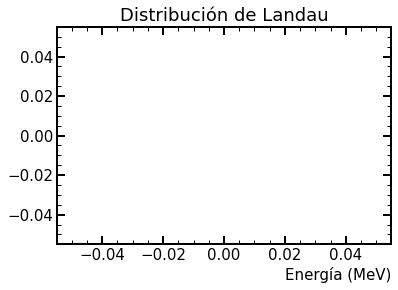

In [55]:
plt.plot(Energy, list_Landau)
plt.xlabel('Energía (MeV)')
plt.title('Distribución de Landau')